In [1]:
!pip install sentence-transformers==2.6.1
!pip install chromadb==0.5.3
!pip install markdown
!pip install beautifulsoup4
!pip install requests
!pip install streamlit
!pip install nltk


## Download NLTK punkt

In [2]:
import nltk
nltk.download('punkt')
nltk.download("punkt_tab")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Clone MkDocs GitHub repo

In [3]:
!git clone https://github.com/mkdocs/mkdocs.git


fatal: destination path 'mkdocs' already exists and is not an empty directory.


## Load and clean markdown files

In [4]:
import os, re
from bs4 import BeautifulSoup

ROOT = "mkdocs/docs"

def read_markdown(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def clean_markdown(md_text):
    # remove code blocks
    md_text = re.sub(r"```.*?```", "", md_text, flags=re.DOTALL)
    # remove HTML tags
    md_text = BeautifulSoup(md_text, "html.parser").get_text()
    # collapse whitespace
    md_text = re.sub(r"\s+", " ", md_text)
    return md_text.strip()

files = []
for root, dirs, fs in os.walk(ROOT):
    for f in fs:
        if f.endswith(".md"):
            files.append(os.path.join(root, f))

len(files)


19

## Sentence-based chunking

In [5]:
from nltk.tokenize import sent_tokenize

def chunk_text(text, max_sentences=5, overlap=2):
    sents = sent_tokenize(text)
    chunks = []
    i = 0
    while i < len(sents):
        chunk = sents[i : i + max_sentences]
        chunks.append(" ".join(chunk))
        i += max_sentences - overlap
    return chunks

chunks = []
for f in files:
    cleaned = clean_markdown(read_markdown(f))
    cks = chunk_text(cleaned)
    for idx, c in enumerate(cks):
        chunks.append({"text": c, "source": f, "id": f"{f}-{idx}"})

len(chunks)


352

In [6]:
# Save RAG chunks for multimodal use
import json

with open("chunks.jsonl", "w", encoding="utf-8") as f:
    for c in chunks:
        json.dump(c, f)
        f.write("\n")

print("chunks.jsonl saved for multimodal system. Total chunks:", len(chunks))


chunks.jsonl saved for multimodal system. Total chunks: 352


## Create Chroma Vector DB and insert embeddings

In [7]:
from chromadb import Client
from chromadb.config import Settings
from sentence_transformers import SentenceTransformer
import os
os.environ["ANONYMIZED_TELEMETRY"] = "false"

model = SentenceTransformer("all-MiniLM-L6-v2")

client = Client(Settings(persist_directory="./chromadb"))
collection = client.get_or_create_collection(name="mkdocs_rag", metadata={"hnsw:space": "cosine"})

texts = [c["text"] for c in chunks]
ids   = [c["id"] for c in chunks]
meta  = [{"source": c["source"]} for c in chunks]

embeddings = model.encode(texts, batch_size=32, show_progress_bar=True)

collection.add(
    ids=ids,
    documents=texts,
    embeddings=embeddings,
    metadatas=meta
)

print("All chunks stored. Chroma persistence is automatic.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionAddEvent: capture() takes 1 positional argument but 3 were given


All chunks stored. Chroma persistence is automatic.


## Use a local open-source LLM

In [8]:
!pip install transformers accelerate bitsandbytes

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-7b-instruct")
model_llm = AutoModelForCausalLM.from_pretrained(
    "tiiuae/falcon-7b-instruct",
    device_map="auto",
    torch_dtype=torch.float16
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Build RAG query function

In [9]:
def answer_query_local(query, k=3):
    q_emb = model.encode([query])
    results = collection.query(query_embeddings=q_emb, n_results=k)
    context = "\n\n".join(results["documents"][0])

    prompt = f"CONTEXT:\n{context}\n\nQUESTION: {query}\nANSWER:"

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    output = model_llm.generate(**inputs, max_new_tokens=300)
    return tokenizer.decode(output[0], skip_special_tokens=True)

print(answer_query_local("How does MkDocs build static sites?"))


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


CONTEXT:
For example, to get a list of all options available for the `build` command run the following: ## Deploying The documentation site that you just built only uses static files so you'll be able to host it from pretty much anywhere. Simply upload the contents of the entire `site` directory to wherever you're hosting your website from and you're done. For specific instructions on a number of common hosts, see the [Deploying your Docs][deploy] page. ## Getting help See the [User Guide] for more complete documentation of all of MkDocs' features. To get help with MkDocs, please use the [GitHub discussions] or [GitHub issues].

For example: When rendering the theme this setting will be passed as the `site_name` context variable. ### site_url Set the canonical URL of the site. This will add a `link` tag with the `canonical` URL to the `head` section of each HTML page. If the 'root' of the MkDocs site will be within a subdirectory of a domain, be sure to include that subdirectory in the

## **Bonus Points**

# Install CLIP and related packages

In [10]:
!pip install transformers Pillow


# Initialize CLIP model for image embeddings

In [11]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model_name = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device).eval()

def embed_image(image_path):
    img = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        features = clip_model.get_image_features(**inputs)
        features = features / features.norm(p=2, dim=-1, keepdim=True)
    return features.cpu().numpy()[0]


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [12]:
from chromadb.config import Settings
from chromadb import Client

client = Client(Settings(persist_directory="./chromadb"))
multi_collection = client.get_or_create_collection(
    name="mkdocs_multimodal_text",
    metadata={"type": "text"}
)

print("Multimodal Chroma collection ready")


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


Multimodal Chroma collection ready


# Add text embeddings to the multimodal collection

In [13]:
text_embeddings = model.encode([c["text"] for c in chunks], batch_size=32, show_progress_bar=True)

for i, c in enumerate(chunks):
    multi_collection.add(
        ids=[f"text-{i}"],
        documents=[c["text"]],
        embeddings=[text_embeddings[i].tolist()],
        metadatas=[{"source": c["source"], "id": c["id"]}]
    )


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionAddEvent: capture() takes 1 positional argument but 3 were given


# Add image embeddings

In [15]:
import os
import shutil
import re
from pathlib import Path
from bs4 import BeautifulSoup
import requests

# Step 5a: Setup directories
DOC_ROOT = Path("mkdocs/docs")  # your markdown docs
IMAGE_OUTPUT_DIR = Path("mkdocs_images_extracted")
IMAGE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Acceptable image extensions
IMG_EXTS = {".png", ".jpg", ".jpeg", ".gif", ".svg", ".webp"}

# Function to extract images from markdown files
def extract_images_from_markdown(doc_root=DOC_ROOT, output_dir=IMAGE_OUTPUT_DIR):
    md_files = list(doc_root.rglob("*.md"))
    print(f"Found {len(md_files)} markdown files for image extraction.")
    img_records = []  # store metadata about images

    for md in md_files:
        text = md.read_text(encoding="utf-8", errors="ignore")
        # regex to find markdown images: ![alt](path "title")
        for m in re.finditer(r'!\[([^\]]*)\]\(([^)]+)\)', text):
            alt = m.group(1).strip()
            link = m.group(2).strip().split()[0].strip()

            # Skip external images (optional: you could download them if desired)
            if link.startswith("http://") or link.startswith("https://"):
                try:
                    r = requests.get(link, timeout=10)
                    if r.status_code == 200:
                        ext = Path(link.split("?")[0]).suffix or ".png"
                        dest_file = output_dir / f"img_{len(img_records)}{ext}"
                        dest_file.write_bytes(r.content)
                        img_records.append({
                            "img_path": str(dest_file),
                            "source_md": str(md),
                            "alt": alt,
                            "orig_link": link
                        })
                except Exception as e:
                    print("Skipping unreachable external image:", link)
                    continue
            else:
                # relative path inside repo
                img_path = (md.parent / link).resolve()
                if img_path.exists() and img_path.suffix.lower() in IMG_EXTS:
                    dest = output_dir / f"{len(img_records)}{img_path.suffix}"
                    shutil.copyfile(img_path, dest)
                    img_records.append({
                        "img_path": str(dest),
                        "source_md": str(md),
                        "alt": alt,
                        "orig_link": str(link)
                    })
                else:
                    # maybe path has leading slash
                    candidate = (DOC_ROOT / link.lstrip("/")).resolve()
                    if candidate.exists() and candidate.suffix.lower() in IMG_EXTS:
                        dest = output_dir / f"{len(img_records)}{candidate.suffix}"
                        shutil.copyfile(candidate, dest)
                        img_records.append({
                            "img_path": str(dest),
                            "source_md": str(md),
                            "alt": alt,
                            "orig_link": str(link)
                        })
                    else:
                        # not found, skip
                        continue

    # Save metadata
    with open("image_index.json", "w", encoding="utf-8") as fh:
        import json
        json.dump(img_records, fh, ensure_ascii=False, indent=2)

    print(f"Extracted {len(img_records)} images to {output_dir}")
    return img_records

# Run image extraction
images = extract_images_from_markdown()


Found 19 markdown files for image extraction.
Extracted 10 images to mkdocs_images_extracted


# Multimodal system +testing (after running the RAG System in the begining restart the runtime and run Multimodal block because Chroma already has an “ephemeral” instance running in memory, and it conflicts with the new persist_directory settings.

  Using cached huggingface_hub-1.1.5-py3-none-any.whl.metadata (13 kB)
Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromad

Multimodal collection ready.
Loading JSONL chunks...
Loaded 352 text chunks.
Loading SentenceTransformer model for text...
Embedding text chunks...


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionAddEvent: capture() takes 1 positional argument but 3 were given


Text chunks inserted successfully.
Images found: 10


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


Image embeddings added (projected to 768-dim).
query_text = How does MkDocs generate websites?

Text Query Results:
["## Getting help See the [User Guide] for more complete documentation of all of MkDocs' features. To get help with MkDocs, please use the [GitHub discussions] or [GitHub issues]. [Installation Guide]: user-guide/installation.md [docs_dir]: user-guide/configuration.md#docs_dir [deploy]: user-guide/deploying-your-docs.md [nav]: user-guide/configuration.md#nav [GitHub discussions]: https://github.com/mkdocs/mkdocs/discussions [GitHub issues]: https://github.com/mkdocs/mkdocs/issues [site_name]: user-guide/configuration.md#site_name [theme]: user-guide/configuration.md#theme [User Guide]: user-guide/README.md", '[rtd]: https://readthedocs.org/ [instructions]: https://docs.readthedocs.io/en/stable/intro/getting-started-with-mkdocs.html ## Other Providers Any hosting provider which can serve static files can be used to serve documentation generated by MkDocs. While it would be

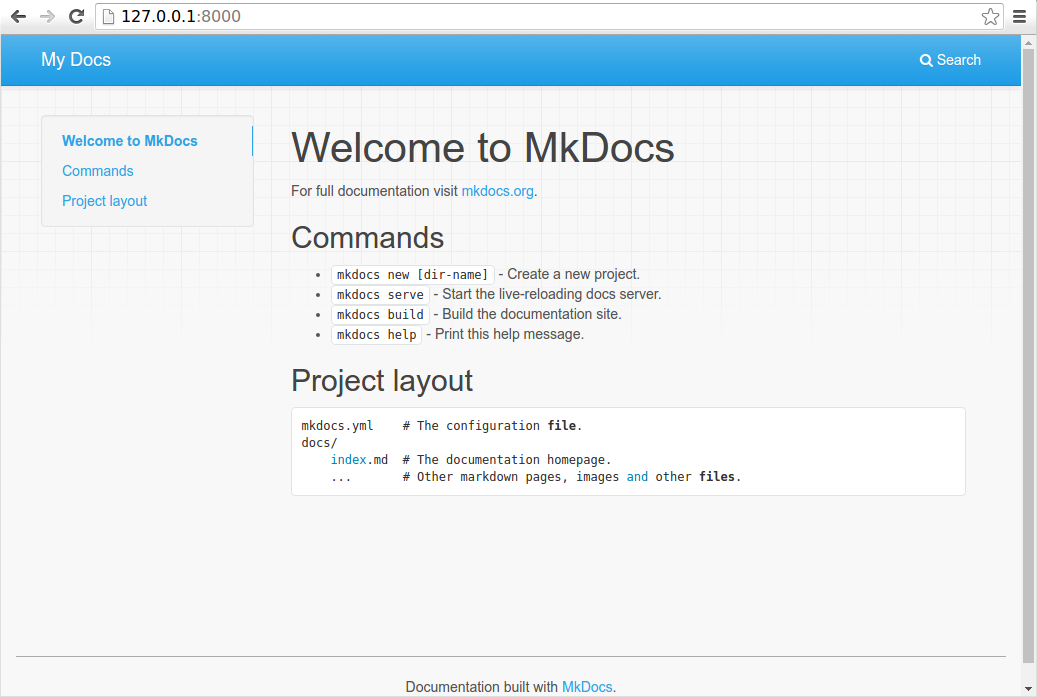

Showing image: /content/mkdocs_images_extracted/1.png


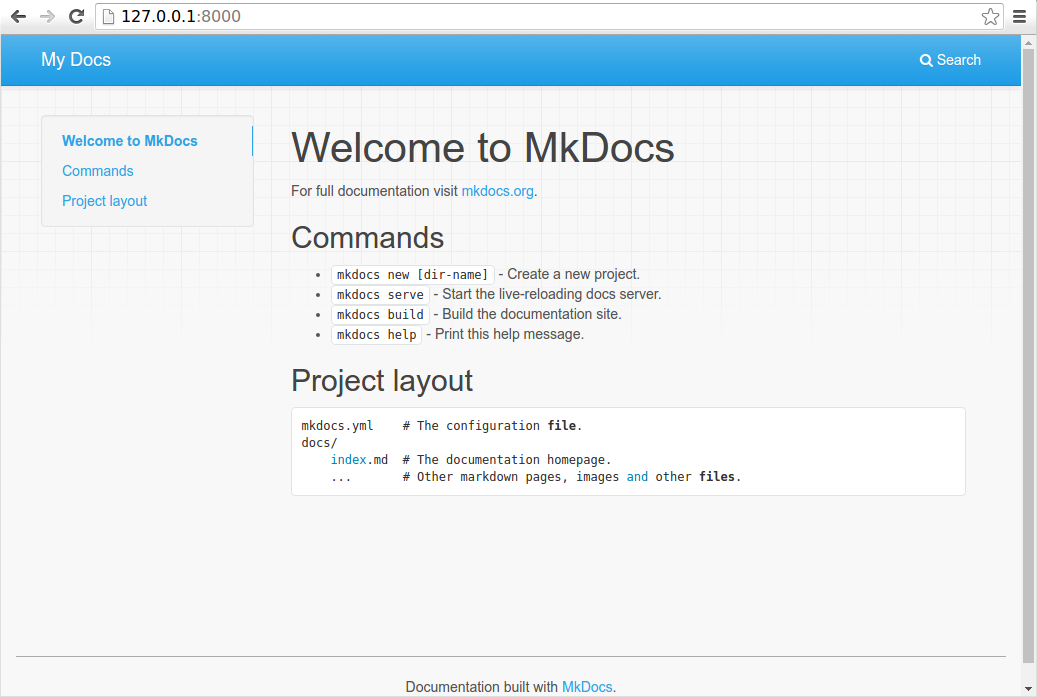

Showing image: /content/mkdocs_images_extracted/5.png


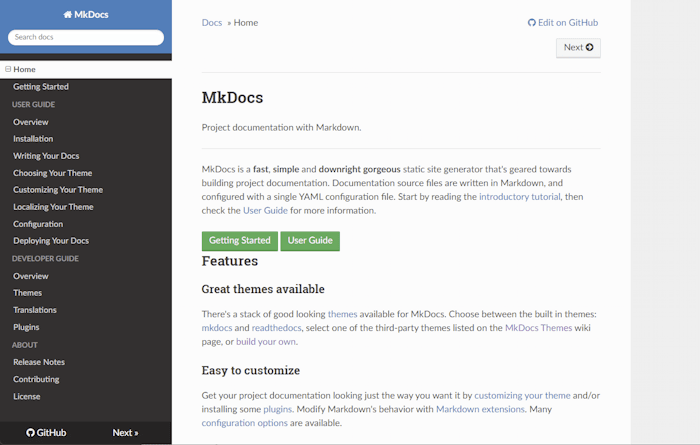

Showing image: /content/mkdocs_images_extracted/9.png


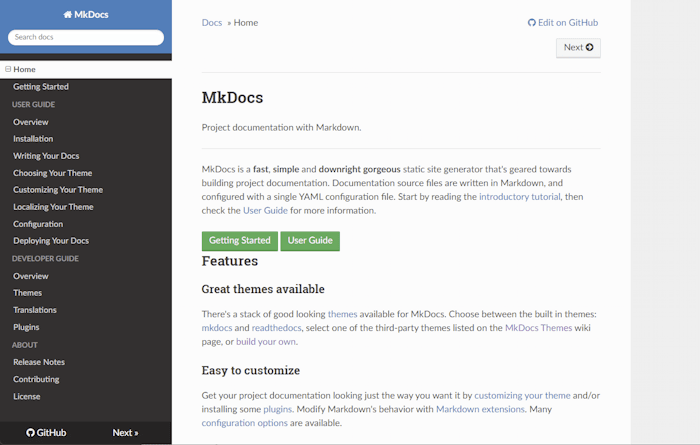

Showing image: /content/mkdocs_images_extracted/3.png


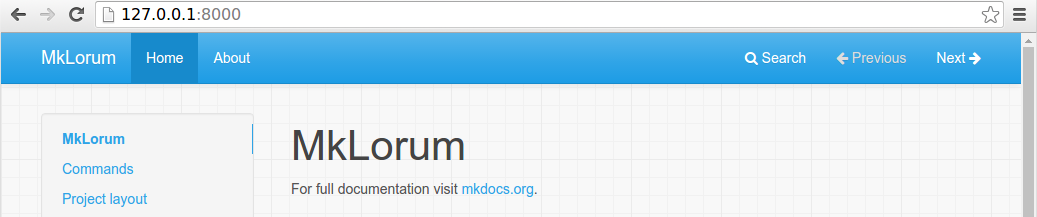

In [1]:

# Multimodal System
# SentenceTransformer for TEXT + CLIP for IMAGES


!pip install --upgrade huggingface_hub transformers sentence-transformers==2.6.1 chromadb==0.5.3


from chromadb import Client
from chromadb.config import Settings
from sentence_transformers import SentenceTransformer
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch
import os
import json
from IPython.display import display


#  Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Load CLIP for images

clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

def embed_image_clip(path):
    img = Image.open(path).convert("RGB")
    inputs = clip_processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = clip_model.get_image_features(**inputs)
    return emb[0].cpu()

# Create or load Chroma collection

persist_dir = "./chromadb_multimodal"
client = Client(Settings(persist_directory=persist_dir))

# Delete old collection if exists
try:
    client.delete_collection("mkdocs_multimodal")
except:
    pass

multi_collection = client.get_or_create_collection(
    name="mkdocs_multimodal",
    metadata={"type": "multimodal"},
)
print("Multimodal collection ready.")


# Load text chunks from JSONL

chunks_file = "/content/chunks.jsonl"
loaded_texts = []
loaded_ids = []

print("Loading JSONL chunks...")
with open(chunks_file, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        try:
            obj = json.loads(line)
            text = obj.get("text", "").strip()
            if text:
                loaded_texts.append(text)
                loaded_ids.append(f"chunk-{i}")
        except:
            pass

print(f"Loaded {len(loaded_texts)} text chunks.")


# Embed text with SentenceTransformer

print("Loading SentenceTransformer model for text...")
text_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", device=device)

def embed_texts_st(text_list):
    return text_model.encode(text_list, batch_size=64, show_progress_bar=True).tolist()

print("Embedding text chunks...")
text_embeddings = embed_texts_st(loaded_texts)

# Add text to Chroma
multi_collection.add(
    documents=loaded_texts,
    embeddings=text_embeddings,
    ids=loaded_ids
)
print("Text chunks inserted successfully.")


# Embed images

image_dir = "/content/mkdocs_images_extracted"
image_paths = [
    os.path.join(image_dir, f)
    for f in os.listdir(image_dir)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
]

print(f"Images found: {len(image_paths)}")

import torch.nn as nn

# Map 512-dim CLIP image embeddings to 768-dim to match text embeddings
proj_layer = nn.Linear(512, 768).to(device)

for i, path in enumerate(image_paths):
    emb_512 = embed_image_clip(path).to(device)       # 512-dim
    emb_768 = proj_layer(emb_512).cpu().tolist()     # map to 768-dim
    multi_collection.add(
        ids=[f"img-{i}"],
        documents=[path],
        embeddings=[emb_768],
        metadatas=[{"source": "image"}]
    )

print("Image embeddings added (projected to 768-dim).")

# Test queries

# Text query
query_text = "How does MkDocs generate websites?"
q_emb_text = text_model.encode([query_text])[0]
res_text = multi_collection.query(
    query_embeddings=[q_emb_text.tolist()],
    n_results=3
)
print("query_text = How does MkDocs generate websites?")
print("\nText Query Results:")
print(res_text["documents"][0])

from IPython.display import display
from PIL import Image

# Query image
query_image_path = image_paths[0]
# Move embedding to device of projection layer
q_emb_img_512 = embed_image_clip(query_image_path).to(proj_layer.weight.device)
q_emb_img_768 = proj_layer(q_emb_img_512).cpu().tolist()  # project to collection dim


res_img = multi_collection.query(
    query_embeddings=[q_emb_img_768],
    n_results=5
)
print("query_text = How does MkDocs generate websites?")
print("\nTop Image Query Results:")

for doc in res_img["documents"][0]:
    if os.path.exists(doc):
        print(f"Showing image: {doc}")
        display(Image.open(doc))
    else:
        print(f"Skipped non-image result: {doc[:80]}{'...' if len(doc)>80 else ''}")



# FastApi app

In [4]:
%%writefile fastapi_app.py
from fastapi import FastAPI, Form
from fastapi.responses import JSONResponse
from fastapi.staticfiles import StaticFiles
import os

# Assumes these are already loaded in memory:
# text_model
# clip_model, clip_processor
# collection
# embed_text(text) and embed_image(img) functions

app = FastAPI(title="Multimodal RAG API")

# Mount images folder
IMAGE_DIR = "/content/mkdocs_images_extracted"  # or "mkdocs_images_extracted"
app.mount("/images", StaticFiles(directory=IMAGE_DIR), name="images")

@app.get("/")
def root():
    return {"message": "Multimodal RAG API is running!"}

@app.post("/search")
async def search(query: str = Form(...), n_results: int = Form(5)):
    if query.strip() == "":
        return JSONResponse(status_code=400, content={"error": "Query is empty"})

    # Embed the text query
    emb = embed_text(query)

    # Query the multimodal collection
    results = collection.query(query_embeddings=[emb], n_results=n_results)

    response = {"query": query, "results": []}
    docs = results["documents"][0]
    metas = results["metadatas"][0]

    for d, m in zip(docs, metas):
        item = {"source": m.get("source", "unknown")}

        # Check if it's an image
        if d.lower().endswith((".png", ".jpg", ".jpeg")) and os.path.exists(d):
            filename = os.path.basename(d)
            item["type"] = "image"
            item["path"] = f"/images/{filename}"  # Serve via FastAPI static route
        else:
            item["type"] = "text"
            item["text"] = d

        response["results"].append(item)

    return response


Overwriting fastapi_app.py


In [8]:
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!sudo dpkg -i cloudflared-linux-amd64.deb


(Reading database ... 121717 files and directories currently installed.)
Preparing to unpack cloudflared-linux-amd64.deb ...
Unpacking cloudflared (2025.11.1) over (2025.11.1) ...
Setting up cloudflared (2025.11.1) ...
Processing triggers for man-db (2.10.2-1) ...


# FastApi using Cloudflared (copy the link into index.html then run the file it will open the web page)

In [9]:
import subprocess
import time

# Start FastAPI
subprocess.Popen(["uvicorn", "fastapi_app:app", "--host", "0.0.0.0", "--port", "8000"])

time.sleep(5)

# Open tunnel
!cloudflared tunnel --url http://localhost:8000 --no-autoupdate


2025-11-27T14:24:30Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-11-27T14:24:30Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-11-27T14:24:34Z INF +--------------------------------------------------------------------------------------------+
2025-11-27T14:24:34Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-11-27T14:24:34Z INF |  https://heated-explained-satisfied-ohio.trycloudflare